# Twitter Sentiment Analysis

### Shunji Wan, 05/07/2023

<a id="0"></a> <br>
 ## Table of Contents  
- [Problem Statement](#1)
- [Data Collection and Preprocessing](#2)
    1. [Kaggle Dataset](#3)
    2. [Exploratory Data Analysis](#4)
    3. [Text Preprocessing](#5)
- [Data Modeling Preparation](#6)
- [Linear Classification Models](#7)
    1. [Logistic Regression](#8)
    2. [Support Vector Machine](#9)
- [Recurrent Neural Networks](#10)
    1. [Tokenization and Sequence Padding](#11)
    2. [Bidirectional GRU Model](#12)
    2. [Bidirectional LSTM Model](#13)
- [BERT](#14)

<a id="1"></a>
## Problem Statement

Natural Language Processing (NLP) focuses on analyzing natural language using text and speech data. It is a field that utilizes techniques from numerous subjects to develop models that could enable computers to understand human language. Applications of NLP include machine translation, text generation, speech recognition, etc., and in this project, we will explore sentiment analysis.

Sentiment analysis aims to determine the emotion behind texts, and it is usually a classification task. It can be done using models that are trained on datasets labeled with sentiment types such as positive, neutral, or negative. Sentiment analysis is useful in a variety of settings. For instance, companies can use sentiment analysis to understand customer opinions on their products and services and thus identify areas to improve.

In this project, we obtained an entity-level sentiment analysis dataset of Twitter from Kaggle. Our objective is to develop models that can classify tweets into positive, negative, and neutral sentiment categories. We will train several linear models and neural networks and compare their performance based on the accuracy scores with the goal of identifying the most effective approach for sentiment classification of tweets.

<a id="2"></a>
## Data Collection and Preprocessing

<a id="3"></a>
### 1. Kaggle Dataset

In [2]:
import pandas as pd
import numpy as np
# !pip install opendatasets
import opendatasets as od # for downloading datasets from url

We start with downloading data from Kaggle using its API.

In [77]:
url = 'https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/download?datasetVersionNumber=2'

od.download(url)

twitter_training_df = pd.read_csv('./twitter-entity-sentiment-analysis/twitter_training.csv', 
                                  names=['id', 'entity', 'sentiment', 'content'])

twitter_validation_df = pd.read_csv('./twitter-entity-sentiment-analysis/twitter_validation.csv', 
                                    names=['id', 'entity', 'sentiment', 'content'])

Skipping, found downloaded files in "./twitter-entity-sentiment-analysis" (use force=True to force download)


The folder contains two datasets, one for training and the other one for validation.

The given training and validation sets are disproportionate and yet we don't have the test set.

Given this, we concatenate these two files and will do the train-test split later in this project.

We take a look at the concatenated dataset.

In [78]:
twitter_df = pd.concat([twitter_training_df, twitter_validation_df])
twitter_df.head()

,id,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


There are four features in this dataset: `id`, `entity`, `sentiment`, and `content`.

In this text classification project, we only need to take care of the last two features. 

Next, we take a look at how many samples we have got.

In [79]:
twitter_df = twitter_df.dropna()
len(twitter_df)

74996

There are plenty!

This amount of samples is sufficient for training models - but the training speed for particular models can be expected to be really slow.

We also explore data types and potential null values in the feature data.

In [80]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74996 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74996 non-null  int64 
 1   entity     74996 non-null  object
 2   sentiment  74996 non-null  object
 3   content    74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.9+ MB


Let's see what sentiments can tweets be labeled.

In [81]:
twitter_df.sentiment.unique().tolist()

['Positive', 'Neutral', 'Negative', 'Irrelevant']

Sentiment can be `Positive`, `Neutral`, `Negative` or `Irrelevant`.

`Irrelevant` means that the tweet has nothing to do with its labeled entity. We can regard them as of neutral sentiment.

Replace all `Irrelevant` entries with `Neutral`.

In [82]:
twitter_df['sentiment'] = twitter_df['sentiment'].replace('Irrelevant', 'Neutral')

Make sure the `sentiment` feature now only has three unique values.

In [83]:
sentiments = twitter_df.sentiment.unique().tolist()
print(sentiments)

['Positive', 'Neutral', 'Negative']


<a id="4"></a>
### 2. Exploratory Data Analysis

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

Next, we check whether our data is balanced with a pie chart.

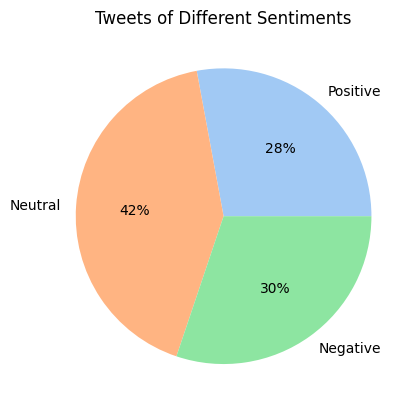

In [85]:
data = []

for s in sentiments:
  tweets = twitter_df[twitter_df['sentiment']==s]
  num_tweets = len(tweets)
  data.append(num_tweets)

colors = sns.color_palette('pastel')[0:5]

plt.pie(data, labels = sentiments, colors = colors, autopct='%.0f%%')
plt.title("Tweets of Different Sentiments")
plt.show()

Although there are 42% tweets are of neutral sentiment, our data is in general fairly balanced.

If the data is significantly imbalanced, the accuracy scores of models may not be promising.

Then, we visualize within each sentiment, how tweets length is distributed.

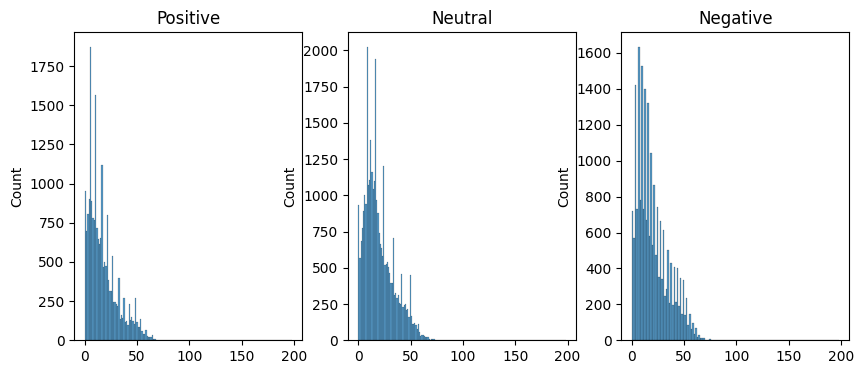

In [86]:
_,axss = plt.subplots(1,3, figsize=[10,4])
idx = 0

for s in sentiments:
  length = [len(tweet.split()) for tweet in 
            twitter_df[twitter_df['sentiment']==s]['content']]
  sns.histplot(length,ax=axss[idx]).set(title=s)
  idx+=1

<a id="5"></a>
### 3. Text Preprocessing

In [1]:
import re
import nltk # for NLP
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

Preprocessing is a crucial step in the text classification task. It helps to reduce the complexity and thus makes it easier for algorithms to identify patterns and relationships between the words and phrases. Text preprocessing, in our case, for tweets, involves the following steps:

- __*Removing URL*__
- __*Removing numbers and punctuation*__
- __*Converting characters into lowercase*__
- __*Tokenization*__
- __*Removing stopwords*__
- __*Stemming or Lemmatization*__
- __*Removing words of particular length*__
- __*Converting tokens back to sentences*__

Some clarifications:

We convert characters into lowercase because, for instance, the models will understand _"tweet"_ and _"Tweet"_ as two separate words.

Stopwords are common words in a language like _"the"_, _"a"_, _"is"_, _"to"_ which do not carry much information, and therefore, we remove them as well.

Both stemming and lemmatization normalize corpus by reducing the inflectional forms of each word into a common base or root. Stemming usually chops off the ends of words and removes derivational units, and lemmatization returns the base or dictionary form of a word. Consider the word _"flew"_ - stemming will process it as _"fl"_ while lemmatization will return _"fly"_. As stemming may create new words with ambiguous meaning, we use lemmatization.

We remove words of, usually, length shorter than 2, especially given that we are dealing with tweets. Because, for instance, if someone typed _"L O L"_, the models will understand it as three individual characters, which give us no information but extra noises.

Now, we define the preprocessing function for texts given our scheme.

In [88]:
def text_preprocessor(text):
    # remove ULR
    text = re.sub(r'http\S+','',text)
    # remove special characters
    text = re.sub('[^a-zA-Z]',' ',text)
    # lowercase conversion
    text = text.lower()
    # tokenization
    words = word_tokenize(text)
    # remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    # lemmatization
    words = [WordNetLemmatizer().lemmatize(word=word,pos='v') for word in words]
    # remove words with 2 or fewer characters
    words = [word for word in words if len(word) > 2]
    # put words back to a sentence
    return ' '.join(words)

We apply the preprocessing function to all tweets in the dataset.

In [89]:
twitter_df['cleaned_content'] = twitter_df['content'].apply(text_preprocessor)

Preprocessing may result in some empty sentences. We filter them out and take a look at the dataset.

In [90]:
twitter_df = twitter_df[twitter_df['cleaned_content'].apply(lambda x: len(x)) > 0]
twitter_df.head()

,id,entity,sentiment,content,cleaned_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,get borderlands murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,come border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,get borderlands kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,come borderlands murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,get borderlands murder


Show some examples of preprocessing outputs.

In [91]:
for i in range(5):
  content = twitter_df['content'].iloc[i]
  cleaned = twitter_df['cleaned_content'].iloc[i]
  print("Orginal Tweet: {content}\nCleaned Tweet: {cleaned}\n".format(content=content,cleaned=cleaned))

Orginal Tweet: im getting on borderlands and i will murder you all ,
Cleaned Tweet: get borderlands murder

Orginal Tweet: I am coming to the borders and I will kill you all,
Cleaned Tweet: come border kill

Orginal Tweet: im getting on borderlands and i will kill you all,
Cleaned Tweet: get borderlands kill

Orginal Tweet: im coming on borderlands and i will murder you all,
Cleaned Tweet: come borderlands murder

Orginal Tweet: im getting on borderlands 2 and i will murder you me all,
Cleaned Tweet: get borderlands murder



We visualize the length distribution of our cleaned tweets.

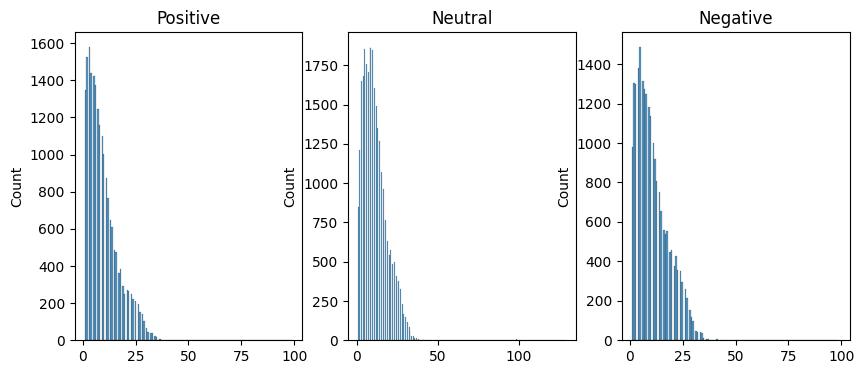

In [92]:
_,axss = plt.subplots(1,3, figsize=[10,4])
idx = 0

for s in sentiments:
  length = [len(tweet.split()) for tweet in 
            twitter_df[twitter_df['sentiment']==s]['cleaned_content']]
  sns.histplot(length,ax=axss[idx]).set(title=s)
  idx+=1

<a id="6"></a>
## Data Modeling Preparation

In [93]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Done with preprocessing, our next step is to prepare the data for fitting models.

We start with defining the maximum vocabulary size. By setting this rather than shooting the size to infinity, the model is forced to focus on the most important words and phrases in the text data, which can improve its ability to generalize observed patterns to new, unseen data.

In [94]:
MAX_VOCAB_SIZE = 50000

Then, we obtain the predictor, which is the cleaned tweets, and our target variable. We label encode the target.

In [95]:
label_encoder = LabelEncoder()
X = twitter_df['cleaned_content']
Y = label_encoder.fit_transform(twitter_df['sentiment'])

We split the data into the training, test, and validation sets.

In [96]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.1, random_state=234)
Xtrain, Xvalidate, Ytrain, Yvalidate = train_test_split(Xtrain, Ytrain, test_size=0.1, random_state=123)

Define a function that helps to show model performance - the confusion matrix and the accuracy score.

In [97]:
def plot_confusion_matrix(model, Xtest, ytest):  
    # make preductions
    predictions = model.predict(Xtest)
    # deal with outputs from different models
    if len(predictions.shape) > 1:
      predictions = np.argmax(predictions, axis=1)
    # plot the confusion matrix
    cm = confusion_matrix(ytest, predictions)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiments,
                yticklabels=sentiments)
    acc = accuracy_score(ytest, predictions)
    # print the accuracy score in the title of plots
    plt.title('Model Accuracy: {acc:.4f}'.format(acc=acc), fontsize=10)
    plt.xlabel('Actual Label', fontsize=10)
    plt.ylabel('Predicted Label', fontsize=10)

With all the processed data, we can start to experiment with different models.

<a id="7"></a>
## Linear Classification Models

In [98]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score

We start with linear models as they are the simplest ones for classification tasks.

To fit text data to linear models, we make use of two techniques: `CountVectorizer` and `TfidfTransformer`.

`CountVectorizer` is a text feature extraction technique that converts a collection of text documents into a matrix of word counts. It takes as input a corpus of text and outputs a sparse matrix where each row represents a document and each column represents a word in the vocabulary, with the entry indicating the frequency of that word in the corresponding document.

`TfdifTransformer` is another technique that is used to transform raw text into a numerical representation. It assigns a weight to each word in the text based on its frequency and inverse document frequency, which helps to identify the most important words in the text for a given classification task.

We initialize a `CountVectorizer` and a `TfdifTransformer` object with our model in a pipeline. This will make fitting data much simpler.

<a id="8"></a>
### 1. Logistic Regression

We start with applying a logistic regression model to our data. Logistic regression works by computing a probability score for each sentiment label, indicating the likelihood that a given text sample is of that particular sentiment. The model can then return the label with the highest probability score. It is fast in training and making predictions but might not work well if the relationship embedded within the data is non-linear. In a text classification task, it is however hard to check for linearity.

We fit our data to a logistic regression model with most of its parameters default, as hyperparameter tunning can be computationally expensive given our sample size. Normally, it is usual to look for optimal performance by applying regularization strength to the model. After training, we show its confusion matrix and the accuracy score while make predictions using the test set.

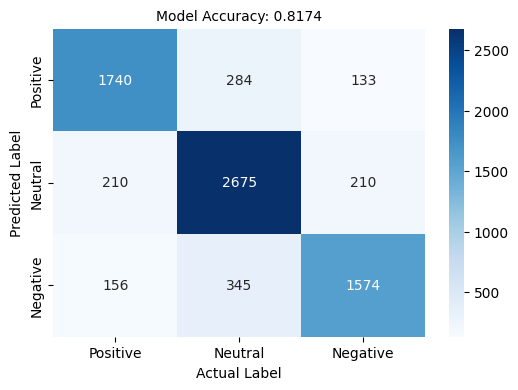

In [99]:
logreg = Pipeline([('cv', CountVectorizer()),
                   ('tt', TfidfTransformer()),
                   ('lr', LogisticRegression(max_iter=500))])

logreg.fit(Xtrain, Ytrain)

plot_confusion_matrix(logreg, Xtest, Ytest)

The logistic regression model gives us an almost 82% accuracy in making predictions.

<a id="9"></a>
### 2. Support Vector Machine

The support vector machine (SVM) is another model that can be applied to the text classification task, known for their ability to handle high-dimensional data and nonlinear relationships between features. SVM works by mapping the text data into a high-dimensional feature space and finding a hyperplane that maximally separates the different labels.

However, a significant drawback of SVM is that it is super computationally expensive to train, especially given our enormous sample size. Due to this concern, instead of using the `svm` class from the `sklearn` library, we initialize a `SGDClassifier` object as an alternative to experiment with. With default parameters, it gives a SVM model, but this prevents us from hyperparameter tunning, exploring different sets of values for the `SVC` object parameters, such as the kernel functions and the regularization parameter.

It can be expected that the performance of our SVM might be not so promising, as it is very sensitive to the choice of hyperparameters. Either way, we take a look at how it goes with our data and compare the performance with that of the previous logistic regression model.

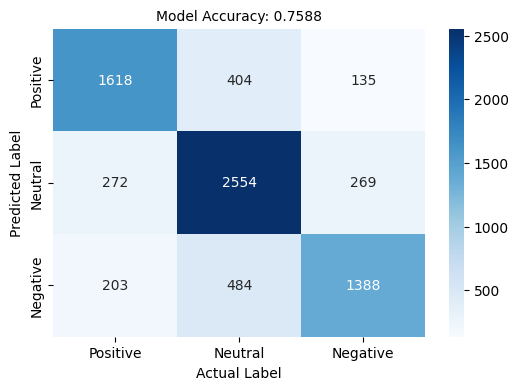

In [100]:
svm = Pipeline([('cv', CountVectorizer()),
                ('tt', TfidfTransformer()),
                ('svm', SGDClassifier(random_state=452))])

svm.fit(Xtrain, Ytrain)

plot_confusion_matrix(svm, Xtest, Ytest)

The SVM model gives us a 76% accuracy in making predictions, which is 6% lower than that of the logistic regression model.

<a id="10"></a>
## Recurrent Neural Networks

In [101]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, MaxPooling1D, Conv1D, LSTM, GRU, Embedding, Bidirectional, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix

While linear models are simple and effective approaches for text classification tasks, they are relatively weak in learning more complex relationships between features and the classes, associations among words. While the logistic regression model and the support vector machine yielded pretty decent accuracy scores, but we wonder whether there are models other than linear ones that could have better performance.

Another category of models to be considered would be neural networks, which can automatically learn hierarchical representations of the text data and thus capture more subtle, nuanced patterns that may not be immediately obvious from the raw text. As one of the most popular and effective choice of neural networks for text classification tasks, recurrent neural networks (RNNs) can model the temporal dependencies in the text data and thus learn context and semantics of natural languages. Unlike linear models, which typically require careful feature selection as well as preprocessing to achieve good performance, RNNs can automatically weight the most important features and thus ignore noises and redundancy in the data.

Now, we will build and compare performances of two types of RNNs - bidirectional GRU and bidirectional LSTM. The ideas behind GRU and LSTM will be discussed later in this section. Bidirectional here in the context means the input sequence is processed in both forward and backward directions. This approach allows the network to capture not only the context before a given input sequence but also the context after and thus provides a more complete representation of the input sequence than either direction alone. For instance, consider the sentence _"The Mathematics course at Vassar"_ - in forward direction, the model will know the _"course"_ is about _"Mathematics"_, and in backward direction, the _"course"_ is at _"Vassar"_.

<a id="11"></a>
### 1. Tokenization and Sequence Padding

Before fitting the text data to the RNNs, we process them into inputs of the appropriate shape and format.

The first step is to tokenize the text data in the training, test, and validation sets. We initialize a `Tokenizer` object from the `Keras` library, specifying the `num_words` parameter with the maximum vocabulary size previously defined so that only the most frequently occurring words will be kept. Then, we fit the `Tokenizer` object on the training set, splitting all cleaned tweets into lists of words and generating the vocabulary. Finally, we call the `texts_to_sequences` method on all sets to convert the text data into sequences of integers, where each integer represents a token from the library.

In [111]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(Xtrain)
sequences_train = tokenizer.texts_to_sequences(Xtrain)
sequences_test = tokenizer.texts_to_sequences(Xtest)
sequences_validate = tokenizer.texts_to_sequences(Xvalidate)

Next, we obtain the dictionary of words using the `word_index` attribute and calculate the size of it.

The dictionary size will later be used as the input size for the neural network models.

In [112]:
word2idx = tokenizer.word_index
V = len(word2idx)
V

23911

The second step is to pad the text data in the training, test, and validation sets. Padding ensures that all input sequences are of the same length. If particular sequences are shorter than the specified length, padding will add zeros to the specified part of the sequences, which enables batch processing of the sequences using matrix operations.

Here, we apply post-padding to the text data, which can be done by setting the `padding` parameter to `post` in the `pad_sequences` function from the `Keras` library. This will add zeros at the end of the sequences. The maximum length of sequences is defined by the longest sequence in the training set.

In [113]:
data_train = pad_sequences(sequences_train, padding='post')
print(data_train.shape)

T = data_train.shape[1]
data_test = pad_sequences(sequences_test, padding='post', maxlen=T)
print(data_test.shape)
data_validate = pad_sequences(sequences_validate, padding='post', maxlen=T)
print(data_validate.shape)

(59343, 129)
(7327, 129)
(6594, 129)


Define a function that plots the training and the validation accuracy and loss through time.

In [105]:
def plot_training_history(r):
  fig, ax = plt.subplots(1, 2, figsize=(10,4))

  # training and validation accuracy
  ax[0].plot(r.history['accuracy'])
  ax[0].plot(r.history['val_accuracy'])
  ax[0].set_title('Accuracy')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('accuracy')
  ax[0].legend(['train', 'validation'], loc='best')

  # training and validation loss
  ax[1].plot(r.history['loss'])
  ax[1].plot(r.history['val_loss'])
  ax[1].set_title('Loss')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('loss')
  ax[1].legend(['train', 'validation'], loc='best')

Define some parameters for later neural network models.

In [106]:
# no. of dimensions in the embedding space
D = 32
# M = 50
epochs = 20
batch_size = 512

<a id="12"></a>
### 2. Bidirectional GRU Model

We at first train and test a bidirectional GRU model.

A Gated Recurrent Unit (GRU) is a type of recurrent neural network that has a gating mechanism that controls the flow of information through the network, allowing it to selectively retain or discard information from the previous time step. It recurrently calculates update gate, reset gate vectors and hidden states. The update gate gives feedback to the model concerning wether we keep the past hidden satte, and the reset gate reinforce the ability to remember of forget components of the past hidden state. Eventually, the hidden state become the weighted sum of the previous hidden states and new values. GRU has faster training speed and better handling of long-term dependencies comparing to trainditional RNNs.

It has fewer parameters than the LSTM model, which will be introduced after this section, and thus are faster to train and less prone to overfitting. However, this also makes it not as effectve as LSTM in capturing very long-term dependencies. Hopefully, the bidirectional processing can help us mitigate this issue. We fit our data to a bidirectional GRU model below and train it in 20 epochs.

In [114]:
# build model
bigru = Sequential()
bigru.add(Embedding(V + 1, D, input_length=T))
bigru.add(Dropout(0.1))
bigru.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
bigru.add(MaxPooling1D(pool_size=2))
bigru.add(Bidirectional(GRU(64, return_sequences=True)))
bigru.add(Bidirectional(GRU(32, kernel_regularizer=regularizers.l2(0.01))))
bigru.add(Dropout(0.1))
bigru.add(Dense(3, activation='softmax'))

# compile model
bigru.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics='accuracy'
)

# train model
bigru_r = bigru.fit(
    data_train,
    Ytrain,
    epochs=epochs,
    validation_data=(data_validate, Yvalidate),
    batch_size=batch_size,
    verbose=0
)

Plot the training and the validation accuracy and loss.

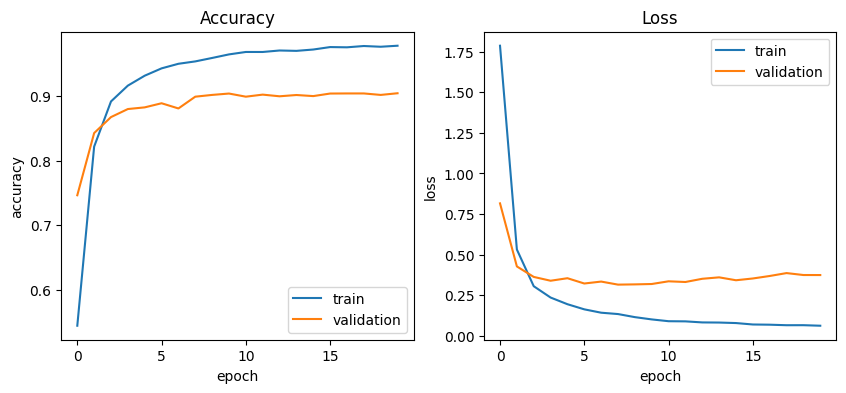

In [115]:
plot_training_history(bigru_r)

Show the confusion matrix and the accuracy score.

229/229 [==============================] - 3s 6ms/step


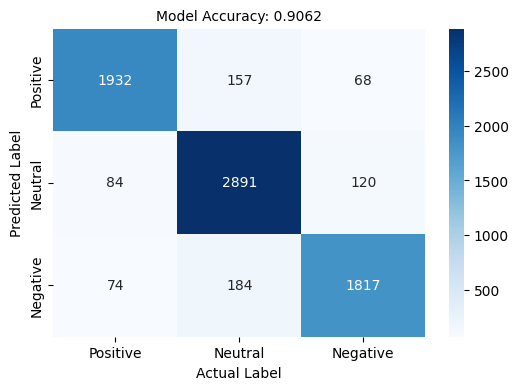

In [116]:
plot_confusion_matrix(bigru, data_test, Ytest)

The bidirectional GRU model results in promising performance and achieve a 91% accuracy - about 10% higher than the logistic regression model!

<a id="13"></a>
### 3. Bidrectional LSTM Model

We then train and test a bidirectional LSTM model.

Long Short-Term Memory (LSTM) is another type of recurrent neural network with a gating mechanism. The cell satte of LSTM stores the memory of the network, and it is controlled by three gates - the input gate, the forget gate, and the output gate. The input gate determines how much new information is allowed to enter the cell state, the forget gate controls how much of the previous cell state should be forgotten, and the output gate determines how much of the cell state should be returned at the current time step.

LSTM has more parameters than the GRU model, and this feature endows it with more power to model long-term dependencies in data. On the other hand, it is computationally expensive and more susceptible to overfitting. Given the complexity of our data, it is hard to predict which one between GRU and LSTM is the better model. We fit our data to a bidirectional LSTM model below and train it in 20 epochs.

In [117]:
# build model
bilstm = Sequential()
bilstm.add(Embedding(V + 1, D, input_length=T))
bilstm.add(Dropout(0.1))
bilstm.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
bilstm.add(MaxPooling1D(pool_size=2))
bilstm.add(Bidirectional(LSTM(64, return_sequences=True)))
bilstm.add(Bidirectional(LSTM(32, kernel_regularizer=regularizers.l2(0.01))))
bilstm.add(Dropout(0.1))
bilstm.add(Dense(3, activation='softmax'))

# compile model
bilstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics='accuracy'
)

# train model
bilstm_r = bilstm.fit(
    data_train,
    Ytrain,
    epochs=epochs,
    validation_data=(data_validate, Yvalidate),
    batch_size=batch_size,
    verbose=0
)

Plot the training and the validation accuracy and loss.

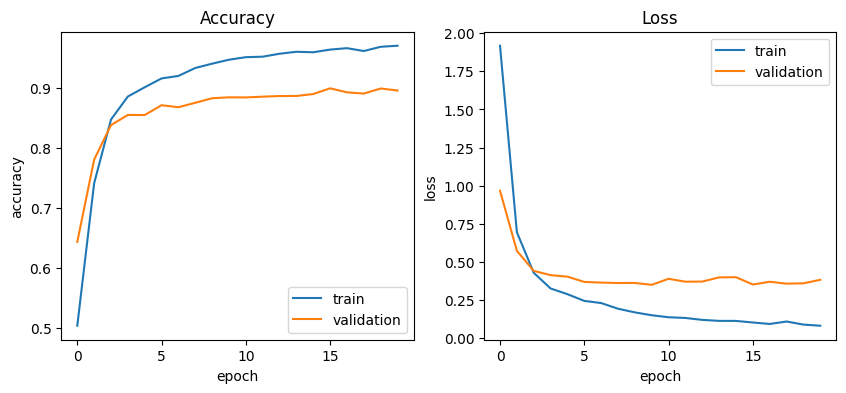

In [118]:
plot_training_history(bilstm_r)

Show the confusion matrix and the accuracy score.

229/229 [==============================] - 3s 6ms/step


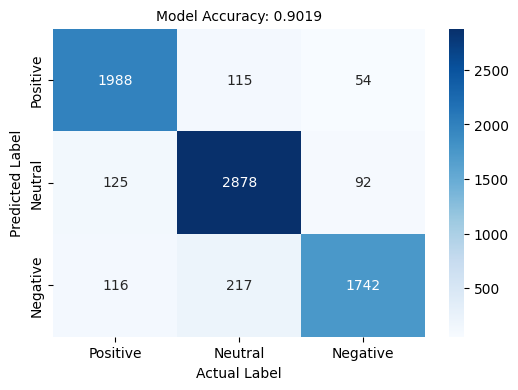

In [119]:
plot_confusion_matrix(bilstm, data_test, Ytest)

The bidirectional LSTM model results in promising performance and achieve a 90% accuracy, which is comparable with the bidirectional GRU model.

<a id="14"></a>
## BERT

In [ ]:
# !pip install ktrain
from ktrain import text
from ktrain import get_learner

After making sentiment analysis with both linear models and neural networks, we briefly walk through BERT (Bidirectional Encoder Representations from Transformers), a pre-trained language model developed by Google in 2018.

BERT a state-of-the-art language model that can be fine-tuned on a wide range of natural language processing tasks. Its transformer-based architecture provides it with great capability to understand text in context. Transformer is a deep learning model in which every output is connected to every input, and the weightings between them are dynamically calculated based upon their connection, a process that is known as the attention mechanism. Given these information, it can be expected that BERT can outperform all previous models.

We start with load the pre-trained BERT model using the `get_learner` function from the `ktrain` library.

In [71]:
(Xtrain, Ytrain), (Xtest, Ytest), prep = text.texts_from_array(x_train=Xtrain.to_numpy(),
                                                               x_test=Xtest.to_numpy(),
                                                               y_train=Ytrain,
                                                               y_test=Ytest,
                                                               class_names=sentiments,
                                                               preprocess_mode='bert',
                                                               maxlen=350)
bert = text.text_classifier('bert', train_data=(Xtrain, Ytrain), preproc=prep)
learner = get_learner(bert, train_data=(Xtrain, Ytrain), batch_size=6)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification
Is Multi-Label? False
maxlen is 350


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


Then, we use the `fit_onecycle` function to train our model.

Be careful to run this chunk as the training process is extremely computationally expensive!

In [ ]:
# took me 2 hours to train
learner.fit_onecycle(2e-5,4)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/4
9891/9891 [==============================] - 1805s 180ms/step - loss: 0.7526 - accuracy: 0.6582
Epoch 2/4
9891/9891 [==============================] - 1786s 181ms/step - loss: 0.4010 - accuracy: 0.8443
Epoch 3/4
9891/9891 [==============================] - 1783s 180ms/step - loss: 0.1700 - accuracy: 0.9381
Epoch 4/4
9891/9891 [==============================] - 1783s 180ms/step - loss: 0.0586 - accuracy: 0.9772


Finally, validate the model using the test set.

In [ ]:
learner.validate(val_data=(Xtest, Ytest), class_names=sentiments)

229/229 [==============================] - 65s 263ms/step
              precision    recall  f1-score   support

    Positive       0.94      0.94      0.94      2157
     Neutral       0.94      0.96      0.95      3095
    Negative       0.94      0.92      0.93      2075

    accuracy                           0.94      7327
   macro avg       0.94      0.94      0.94      7327
weighted avg       0.94      0.94      0.94      7327



array([[2028,   85,   44],
       [  68, 2959,   68],
       [  68,  101, 1906]])

As expected, our trained BERT gives us a 94% accuracy, about 3% higher than the bidirectional GRU model as well as the bidirectional LSTM model. However, given its slow training speed, maybe the neural network models are more appropriate for our task on local machines.